In [1]:
from ipynb.fs.full.interpolation_functions import *
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

In [2]:
# read fesom mesh
mesh = pf.load_mesh('/work/ab0995/a270185/meshes/AO_40/')

/work/ab0995/a270185/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0995/a270185/meshes/AO_40/pickle_mesh_py3_fesom2


In [3]:
data_path = '/work/ab0995/a270185/AO_1km_ice/'

year = 2015

a_ice = pf.get_data(data_path, 'a_ice', year, mesh, compute=False, how=None)
u_ice = pf.get_data(data_path, 'uice', year, mesh, compute=False, how=None)
v_ice = pf.get_data(data_path, 'vice', year, mesh, compute=False, how=None)

Depth is None, 3d field will be returned
Depth is None, 3d field will be returned
Depth is None, 3d field will be returned


In [4]:
# read latitudes and longitudes from fesom mesh

fesom_mesh = xr.open_dataset('/work/ab0995/a270185/meshes/AO_40/fesom.mesh.diag.nc')

model_lons = fesom_mesh.lon.values
model_lats = fesom_mesh.lat.values

nonan = ~(np.isnan(model_lons) | np.isnan(model_lats))
model_lons_nonan = model_lons[nonan]
model_lats_nonan = model_lats[nonan]

In [5]:
ntimesteps = 30
startday = 0

In [6]:
do_everything(a_ice, u_ice, v_ice, model_lons_nonan, model_lats_nonan,
              ntimesteps, startday, 'data/ice_2015.nc'
             )

0
10
20


The pyfesom interpolation is also nearest neighbour (not needed anymore, just included here as a look up)

In [11]:
# create interpolation grid
box = (-180, 180, 60, 90)
res = (1000, 1000)
proj = 'np'

int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

a_ice_int = np.zeros((ntimesteps,*int_lons.shape))
u_ice_int = np.zeros_like(a_ice_int)
v_ice_int = np.zeros_like(a_ice_int)

In [12]:
%%time
# pyfesom interpolation (this also nearest neighbour)
for i in range(ntimesteps):
    a_ice_int[i] = pf.fesom2regular(np.array(a_ice[i]), mesh, int_lons, int_lats)
    u_ice_int[i] = pf.fesom2regular(np.array(u_ice[i]), mesh, int_lons, int_lats)
    v_ice_int[i] = pf.fesom2regular(np.array(v_ice[i]), mesh, int_lons, int_lats)
    
    if i%10==0: print(i)

0
10
20
CPU times: user 1.78 s, sys: 3.85 s, total: 5.62 s
Wall time: 5.75 s


In [13]:
# create nc file
ds = nc.Dataset(f'data/ice_test_pyfesom.nc', 'w', format='NETCDF4')

x = ds.createDimension('x', np.shape(a_ice_int)[2])
y = ds.createDimension('y', np.shape(a_ice_int)[1])
time = ds.createDimension('time', ntimesteps)

x = ds.createVariable('x', 'f4', ('x',))
y = ds.createVariable('y', 'f4', ('y',))
time = ds.createVariable('time', 'f4', ('time'))

a = ds.createVariable('A', 'f4', ('time','y','x'))
u = ds.createVariable('U', 'f4', ('time','y','x'))
v = ds.createVariable('V', 'f4', ('time','y','x'))
lon = ds.createVariable('ULON', 'f4', ('y','x'))
lat = ds.createVariable('ULAT', 'f4', ('y','x'))

x[:] = np.arange(np.shape(a_ice_int)[2],dtype='int')
y[:] = np.arange(np.shape(a_ice_int)[1],dtype='int')
time[:] = np.arange(ntimesteps)
a[:,:,:] = a_ice_int
u[:,:,:] = u_ice_int
v[:,:,:] = v_ice_int
lon[:,:] = int_lons
lat[:,:] = int_lats

ds.close()

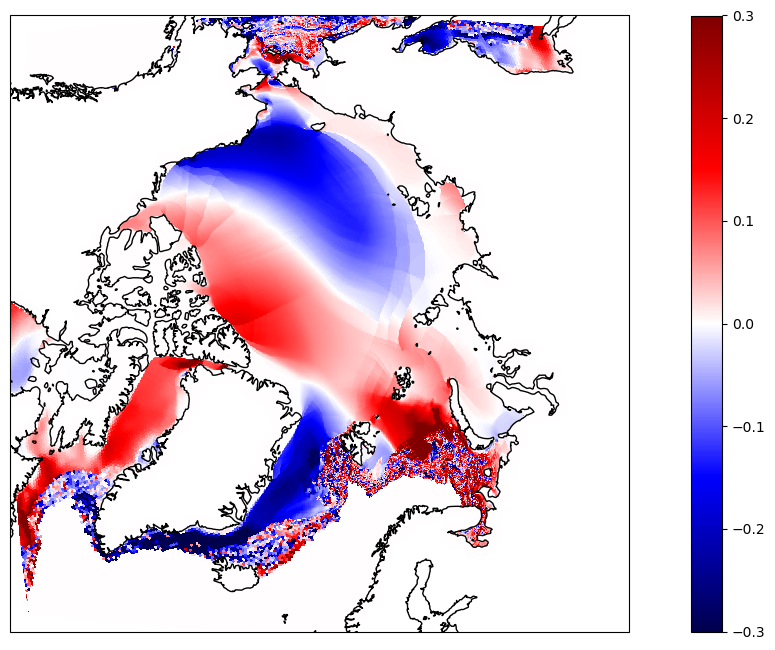

In [14]:
# plot the interpolated data
test = xr.open_dataset(f'data/ice_test_pyfesom.nc')

fig = plt.figure(figsize=[16, 8])
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines(zorder=3)
im = ax.pcolormesh(test.ULON, test.ULAT,
                   test.U.isel(time=0),
                   cmap = 'seismic',
                   vmin=-0.3, vmax=0.3,
                   transform=ccrs.PlateCarree())
plt.colorbar(im)

[<GeoAxesSubplot:>]

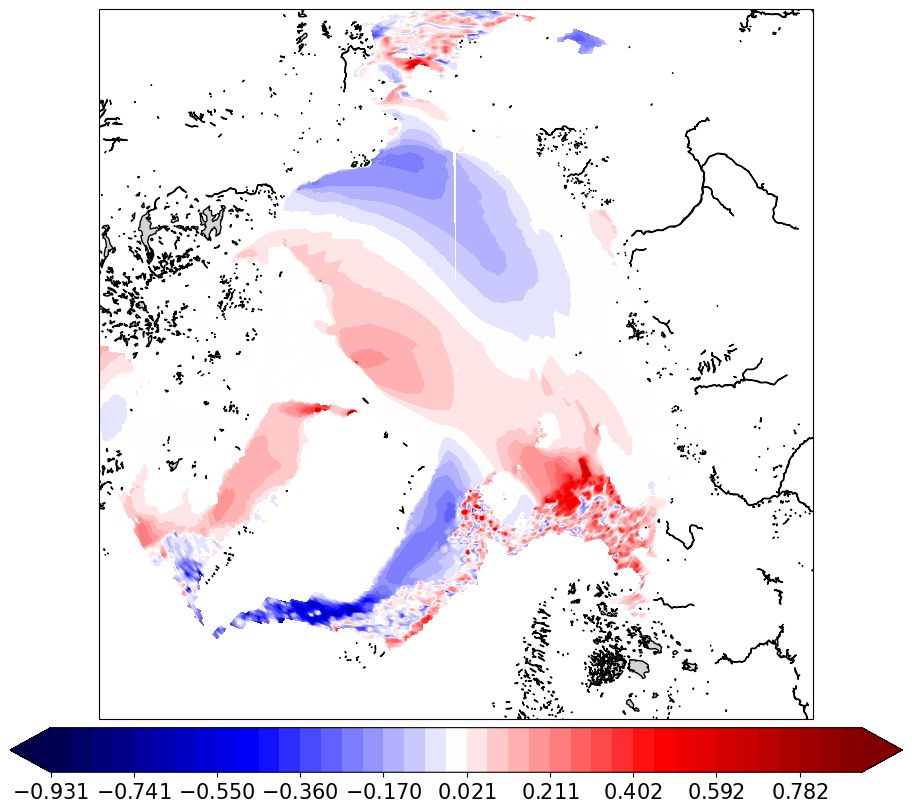

In [18]:
# plot the original data
pf.plot(mesh, u_ice[0,:].values,
        mapproj='np', box=[-180, 180, 60, 90],
        cmap = 'seismic',
       figsize=(10,8))